# The prediction about None-Bayes SegNet with MaSTr1325

In [3]:
import os
from PIL import Image
import numpy as np
import json
import re
# root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation/Dataset/MaSTr1325")
input_path = '../Dataset/MaSTr1325/val_mask/'
output_path = '../Dataset/MaSTr1325/val_json/'
print(os.getcwd())

num = len([f for f in os.listdir(input_path) if f.endswith('m.png')])

pattern = re.compile(r'^\d{3}m\.png$')

for i in range(1, num + 1):
    # construct folder paths
    filename = f"{i:03d}m.png"
    json_name = filename.replace('.png', '.json')
    json_path = os.path.join(output_path, json_name)
    png_path = os.path.join(input_path, filename)
    
    # convert into json file
    image = Image.open(png_path)
    image_data = np.array(image)
    image_data_list = image_data.tolist()
    with open(json_path, 'w') as json_file:
        json.dump(image_data_list, json_file)

/home/zy/BDL/BDL-based-semantic-segmentation/None-Bayes-SegNet


# Ground Truth of 001 image in Validation Dataset

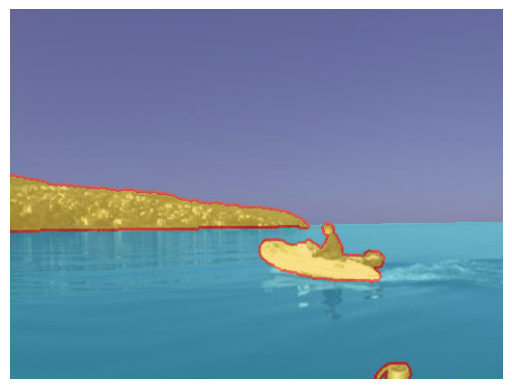

In [6]:
import os
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt

# Path
img_number = '001'
root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
jpg_path = os.path.join(root, f'Dataset/MaSTr1325/val/{img_number}.jpg')
json_path = os.path.join(root, f'Dataset/MaSTr1325/val_json/{img_number}m.json')

# Define Colour
i = 64
colors = {
    0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
    1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
    2: (90, 75, 164, 128),     # purple (RGBA) = sky
    4: (255, 0, 0, 128)       # red (RGBA) = unknown
}

image = Image.open(jpg_path).convert('RGBA')
with open(json_path, 'r') as json_file:
    mask_data = json.load(json_file)
mask_array = np.array(mask_data)
mask_image = Image.new('RGBA', image.size)
mask_pixels = mask_image.load()

for y in range(mask_array.shape[0]):
    for x in range(mask_array.shape[1]):
        value = mask_array[y, x]
        if value in colors:
            mask_pixels[x, y] = colors[value]

# apply mask to jpg
combined = Image.alpha_composite(image, mask_image)
    
plt.imshow(combined)
# plt.imshow(mask_image)
plt.axis('off') 
plt.show()


# Result of Val 001 training for 50 epochs

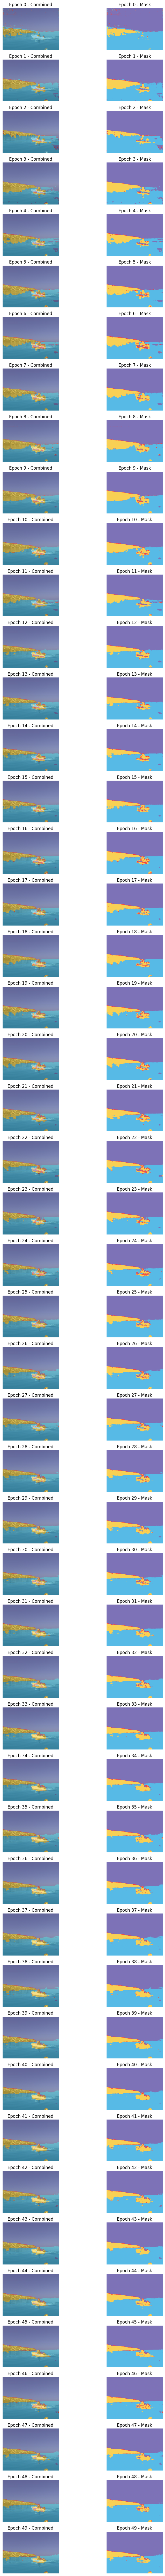

In [9]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

# Path
img_number = '001'
root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
jpg_path = os.path.join(root, f'Dataset/MaSTr1325/val/{img_number}.jpg')
json_root = os.path.join(root, f'None-Bayes-SegNet/result/prediction')

# Constants
threshold = 0.35
colors = {
    0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
    1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
    2: (90, 75, 164, 128),     # purple (RGBA) = sky
    4: (255, 0, 0, 128)        # red (RGBA) = unknown
}

mask_colors = {
    0: (247, 195, 37, 200),    # yellow (RGBA) = obstacle & environment
    1: (41, 167, 224, 200),    # cyan-blue (RGBA) = water
    2: (90, 75, 164, 200),     # purple (RGBA) = sky
    4: (255, 0, 0, 200)        # red (RGBA) = unknown
}

# Load the original image
image = Image.open(jpg_path).convert('RGBA')

# Set up the plot
fig, axes = plt.subplots(50, 2, figsize=(10, 100))

# Process each epoch
for epoch in range(50):
    json_path = os.path.join(json_root, f'epoch_{epoch}_{img_number}m.png.json')

    with open(json_path, 'r') as json_file:
        prediction = json.load(json_file)

    # Convert to numpy array
    predictions = np.array(prediction)
    predictions = np.transpose(predictions, (1, 2, 0))
    predictions_indices = np.argmax(predictions, axis=2)
    predictions_values = np.max(predictions, axis=2)
    predictions_indices[predictions_values < threshold] = 4

    # Create the mask image
    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(predictions_indices.shape[0]):
        for x in range(predictions_indices.shape[1]):
            value = predictions_indices[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]

    # Combine jpg and prediction mask
    combined = Image.alpha_composite(image, mask_image)

    # Create the mask image
    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(predictions_indices.shape[0]):
        for x in range(predictions_indices.shape[1]):
            value = predictions_indices[y, x]
            if value in mask_colors:
                mask_pixels[x, y] = mask_colors[value]

    # Display the combined image and mask separately
    ax_combined = axes[epoch, 0]
    ax_mask = axes[epoch, 1]

    ax_combined.imshow(combined)
    ax_combined.axis('off')
    ax_combined.set_title(f'Epoch {epoch} - Combined')

    ax_mask.imshow(mask_image)
    ax_mask.axis('off')
    ax_mask.set_title(f'Epoch {epoch} - Mask')

plt.tight_layout()
plt.show()


# Convergence Curve IOU vs Dice Coefficiency
$$
\text{IOU} = \frac{\text{Area of Intersection}}{\text{Area of Union}} = \frac{\text{ground truth} \cap \text{prediction}}{\text{ground truth} \cup \text{prediction}}
$$
<br>

$$
\text{Dice-Sørensen} = \frac{2 \times |\text{ground truth} \cap \text{prediction}|}{|\text{ground truth}| + |\text{prediction}|}
$$

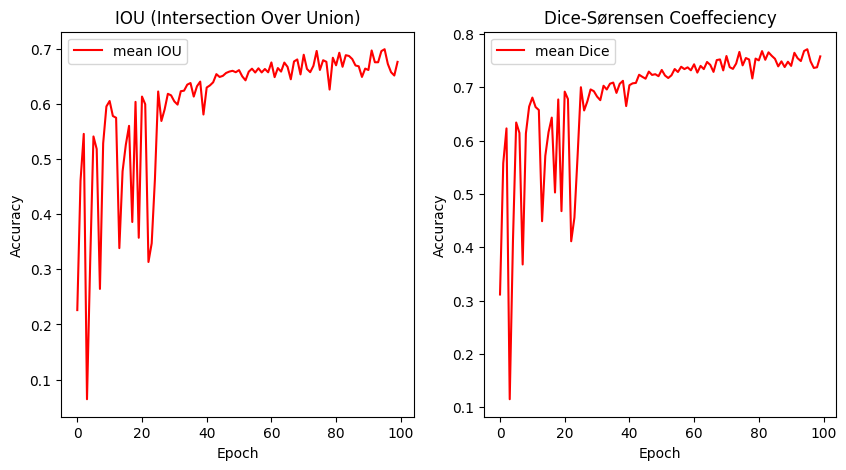

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('result/iou-dice-epoch100.json', 'r') as file:
        data = json.load(file)
aver_iou = np.array([item['aver_iou'] for item in data])
aver_dice = np.array([item['aver_dice'] for item in data])


# Plot figure
plt.figure(figsize=(10, 5))

# 绘制 aver_iou
plt.subplot(1, 2, 1)
plt.plot(aver_iou, label='mean IOU', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('IOU (Intersection Over Union)')
plt.legend()

# 绘制 aver_dice
plt.subplot(1, 2, 2)
plt.plot(aver_dice, label='mean Dice', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Dice-Sørensen Coeffeciency')
plt.legend()

# Training Loss
![avater](result/plot/segnet_1_MaSTr1325_100_loss.jpg)